# 电池数据异常检测
### 此notebook为异常检测比赛的参考DEMO(适用于paddle框架），包括数据划分、模型训练和结果检测等

In [2]:
import numpy as np
from glob import glob
import pandas as pd
import random
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import auc
import paddle
import pickle
import paddle.nn as nn
from paddle.io import Dataset
import pyod
from pyod.utils.stat_models import pairwise_distances_no_broadcast
from paddle.optimizer.lr import LinearWarmup
from paddle.optimizer.lr import CosineAnnealingDecay
from paddle.nn import Linear, Dropout, ReLU, Sigmoid
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt

### 加载训练集的pkl文件

训练集的label存放在pkl里面，可以通过它并区分正常片段和异常片段  
注意需要输入训练集对应的路径

In [13]:
from glob import glob
import pickle
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

data_path='Train'#存放数据的路径
pkl_files = glob(data_path+'/*.pkl')
ind_pkl_files = []#存放标签为0的文件
ood_pkl_files = []#存放标签为1的文件
for each_path in tqdm(pkl_files):
    #下载pkl文件
    pic = open(each_path,'rb')
    this_pkl_file= pickle.load(pic)
    if this_pkl_file[1]['label'] == '00':
        ind_pkl_files.append(each_path)
    else:
        ood_pkl_files.append(each_path)

random.seed(0)
random.shuffle(ind_pkl_files)
random.shuffle(ood_pkl_files)
len(ind_pkl_files),len(ood_pkl_files)

100%|██████████| 28389/28389 [00:06<00:00, 4597.01it/s]


(23735, 4654)

# 数据分析

In [14]:
def  load_data(pkl_list,label=True):
    '''
    输入pkl的列表，进行文件加载
    label=True用来加载训练集
    label=False用来加载真正的测试集，真正的测试集无标签
    '''
    X = []
    y = []
    

    for  each_pkl in pkl_list:
        pic = open(each_pkl,'rb')
        item= pickle.load(pic)#下载pkl文件
        # 此处选取的是每个滑窗的最后一条数据，仅供参考，可以选择其他的方法，比如均值或者其他处理时序数据的网络
        # 此处选取了前7个特征，可以需求选取特征数量
        feature = item[0][:,0:8][-1]
        feature=np.append(feature,item[1]["mileage"])
        X.append(feature)
        if label:
            y.append(int(item[1]['label'][0]))
    X = np.vstack(X)
    if label:
        y = np.vstack(y)
    return X, y
X_train,y_train=load_data(ind_pkl_files)
X_test,y_test=load_data(ood_pkl_files)

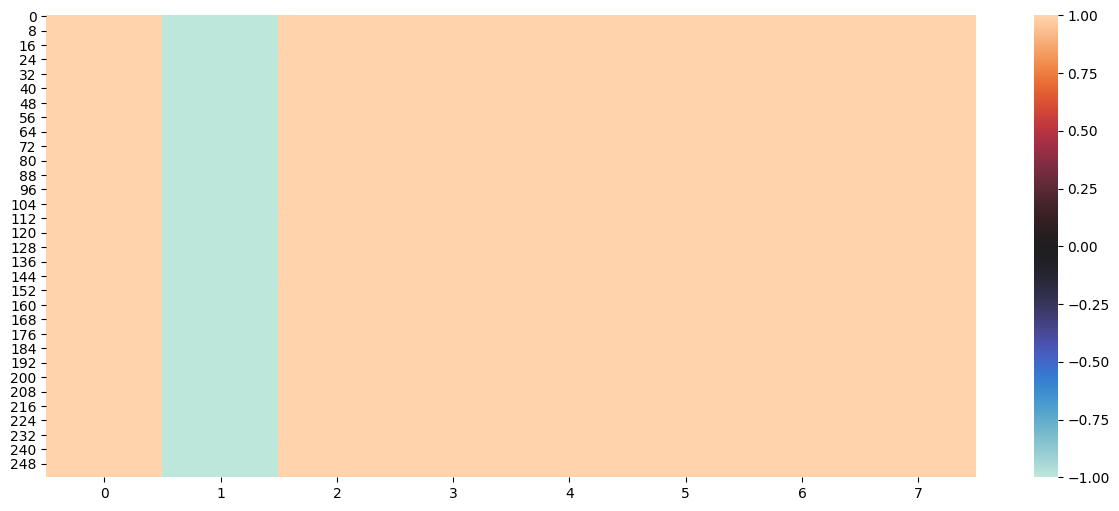

In [15]:
pic = open(ood_pkl_files[0],'rb')
item= pickle.load(pic)#下载pkl文件
item[0].shape
#sns.heatmap(item[0][:,0:])
plt.figure(figsize=(15,6))
sns.heatmap(item[0][:,0:8], vmax=1, vmin=-1, center=0)


In [16]:

zhengchang = pd.DataFrame(X_train,columns=['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','tm','mileage'])
zhengchang["label"] = 0
yichang = pd.DataFrame(X_test,columns=['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','tm','mileage'])
yichang["label"] = 1
zhengchang

,volt,current,soc,max_single_volt,min_single_volt,max_temp,min_temp,tm,mileage,label
0,149.4,-4.6,21.0,1.662,1.659,60.0,54.0,743.0,1292.4,0
1,169.1,-5.5,59.1,1.881,1.876,186.0,174.0,31044.0,2126.7,0
2,167.0,-10.8,48.3,1.858,1.839,174.0,156.0,5409.0,2520.8,0
3,160.0,-11.6,45.7,1.780,1.768,204.0,192.0,2634.0,17465.7,0
4,153.8,-43.4,32.4,1.715,1.707,198.0,192.0,1579.0,4038.3,0
...,...,...,...,...,...,...,...,...,...,...
23730,151.9,-5.2,36.8,1.691,1.685,210.0,198.0,1571.0,2493.8,0
23731,160.1,-4.6,47.0,1.781,1.774,198.0,174.0,6066.0,5376.1,0
23732,167.4,-5.3,58.4,1.862,1.857,192.0,174.0,3218.0,0.0,0
23733,153.5,-20.8,37.5,1.708,1.700,192.0,180.0,2621.0,15277.9,0


In [17]:
yichang

,volt,current,soc,max_single_volt,min_single_volt,max_temp,min_temp,tm,mileage,label
0,149.4,-4.3,31.8,1.663,1.658,216.0,204.0,9728.0,22617.9,1
1,168.4,-4.6,52.7,1.874,1.856,174.0,156.0,43926.0,8101.1,1
2,154.0,-21.0,43.2,1.719,1.705,180.0,156.0,2631.0,30704.7,1
3,159.8,-11.6,38.7,1.777,1.761,168.0,162.0,2296.0,7804.7,1
4,155.0,-5.3,47.0,1.724,1.712,192.0,174.0,34453.0,9103.9,1
...,...,...,...,...,...,...,...,...,...,...
4649,157.7,-45.5,31.8,1.757,1.740,252.0,240.0,1514.0,8312.0,1
4650,148.9,-5.3,16.5,1.656,1.650,198.0,192.0,6812.0,8365.4,1
4651,169.2,-14.6,62.9,1.883,1.876,282.0,264.0,3913.0,12799.5,1
4652,165.0,-35.1,58.4,1.844,1.810,258.0,240.0,2631.0,33253.0,1


volt	current	soc	max_single_volt	min_single_volt	max_temp	min_temp	mileage

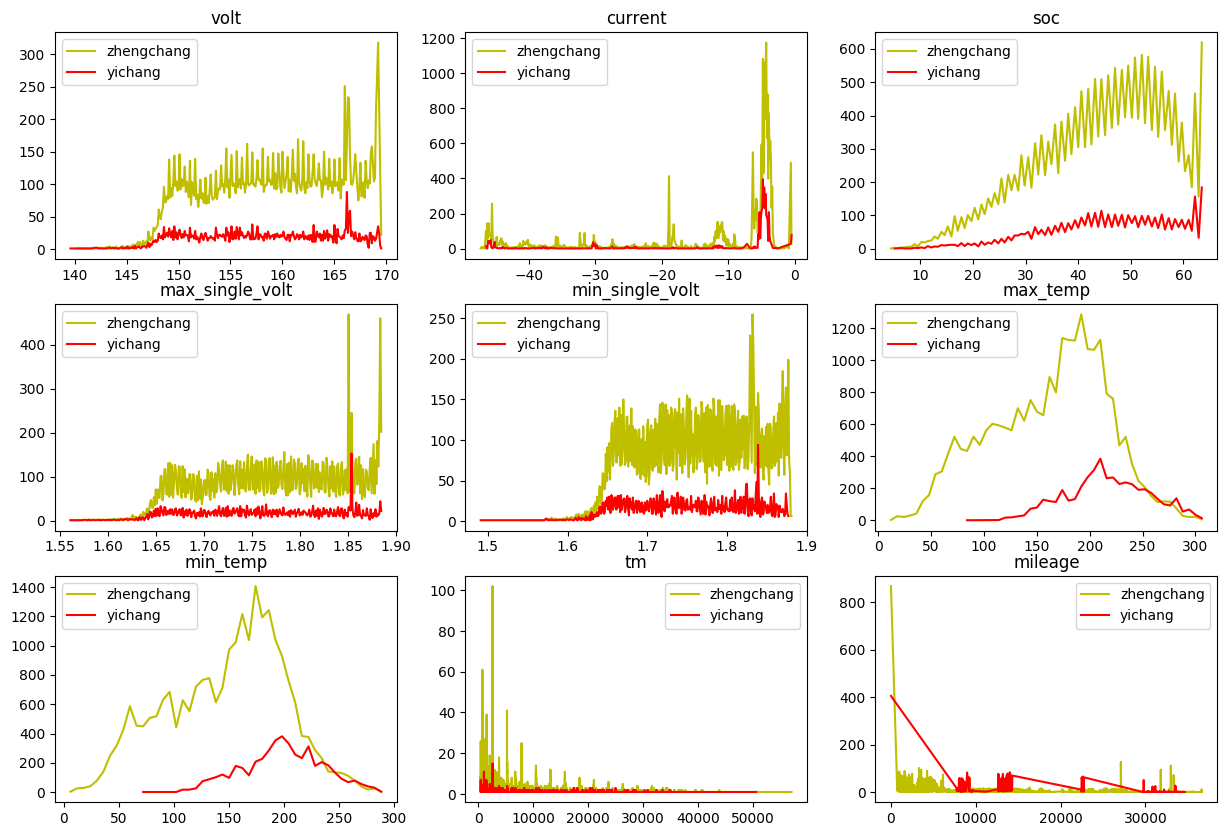

In [19]:

#for i in ['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','tm','mileage']:
columns_list = ['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','tm','mileage']
fig = plt.figure(figsize=(15,10))
for j in range(1,4):
    for k in range(1,4):
        if j == 1:
            index = k - 1
        elif j == 2:
            index = 3 + k - 1 
        else:
            index = 6 + k - 1
        #string = "3" + str(j) + str(index+1)
        string = "33" + str(index+1)
        plt.subplot(int(string))
        zhengchang[columns_list[index]].value_counts().sort_index().plot(kind='line',color="y",label="zhengchang")
        yichang[columns_list[index]].value_counts().sort_index().plot(kind='line',color="r",label="yichang")
        plt.title(columns_list[index])
        plt.legend()
plt.show()

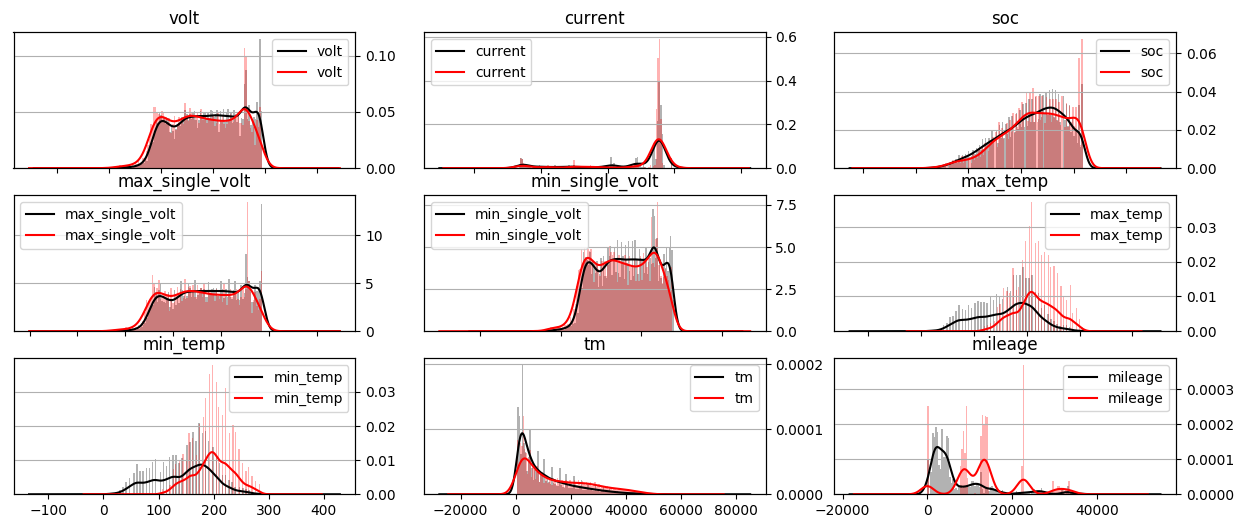

In [20]:
#for i in ['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','tm','mileage']:
columns_list = ['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','tm','mileage']
fig = plt.figure(figsize=(15,6))
for j in range(1,4):
    for k in range(1,4):
        if j == 1:
            index = k - 1
        elif j == 2:
            index = 3 + k - 1 
        else:
            index = 6 + k - 1
        #string = "3" + str(j) + str(index+1)
        string = "33" + str(index+1)
        plt.subplot(int(string))
        zhengchang[columns_list[index]].plot(kind = 'kde',color='k', secondary_y=True)
        zhengchang[columns_list[index]].hist(bins=100,alpha=0.3,color='k',density=True)   #生成直方图
        yichang[columns_list[index]].plot(kind = 'kde',color='r', secondary_y=True)
        yichang[columns_list[index]].hist(bins=100,alpha=0.3,color='r',density=True)   #生成直方图
        plt.title(columns_list[index])
        plt.legend()
plt.show()

(256, 8)


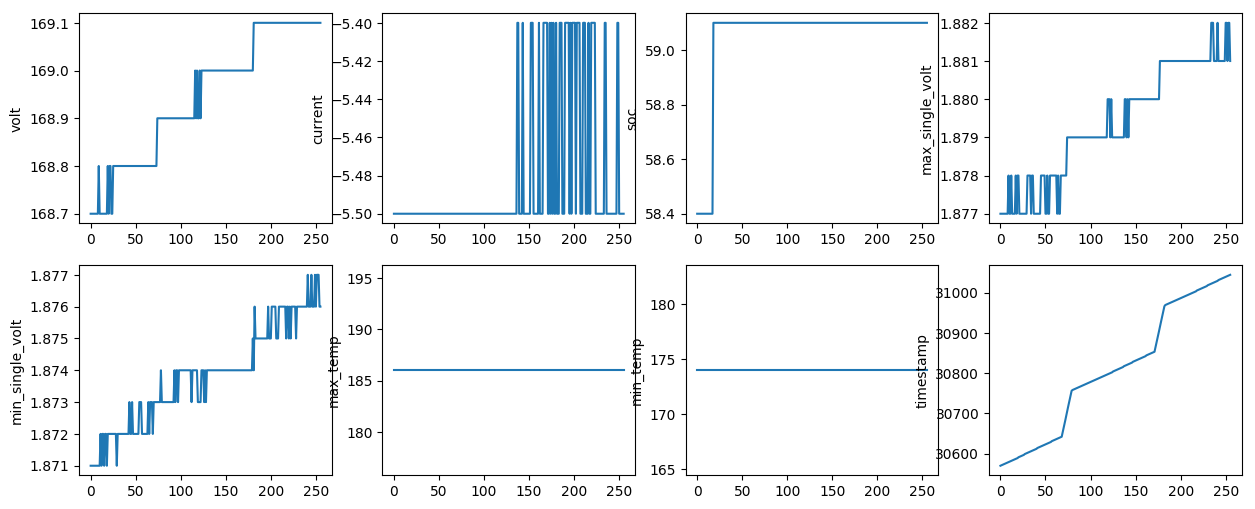

In [21]:
file_00 = ind_pkl_files[1]
#下载pkl文件
pic = open(file_00,'rb')
this_pkl_file= pickle.load(pic)
print(this_pkl_file[0].shape)

tit_label=['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','timestamp']
fig = plt.figure(figsize=(15,6))
for i in range(1,9):
    sub = eval("24"+str(i))
    plt.subplot(sub)
    plt.plot(this_pkl_file[0][:,i-1])
    plt.ylabel(tit_label[i-1])
    #plt.savefig(f"{tit_label[i-1]}.png")

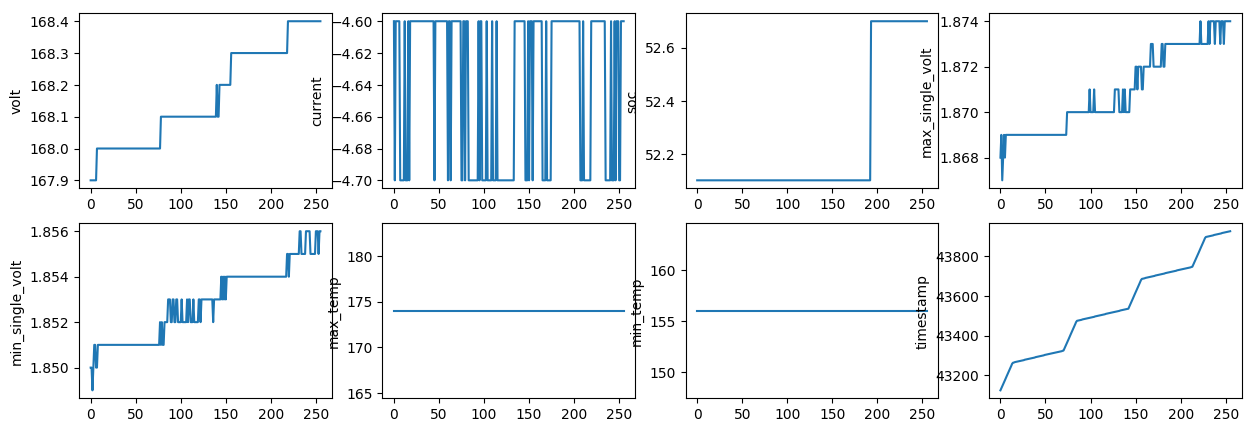

In [22]:
file_00 = ood_pkl_files[1]
#下载pkl文件
pic = open(file_00,'rb')
this_pkl_file= pickle.load(pic)
tit_label=['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','timestamp']
fig = plt.figure(figsize=(15,5))
for i in range(1,9):
    sub = eval("24"+str(i))
    plt.subplot(sub)
    plt.plot(this_pkl_file[0][:,i-1])
    plt.ylabel(tit_label[i-1])